The goal of this notebook is to come up with the best model (out of a few possibilites) that will use the Titanic disaster data to predict the likelihood that a passenger survived (or not)      
By analyzing the available data the model will return a prediction of 1 for "survived" and 0 for "deceased"    
The idea is to take the available data and split it into two sets: "training" and "testing"; the prediction model will be built on the training set while the testing set will be used to measure the accuracy of the model   

### Importing needed libraries and reading data file

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

Reading the csv file below, checking to see that the file was read correctly, and see what the first 5 rows look like  

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Some exploratory analysis

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From this I notice that of the 891 entries the features Age, Cabin, and Embarked have some missing values

Visualization below to expose the features with missing values (white lines)

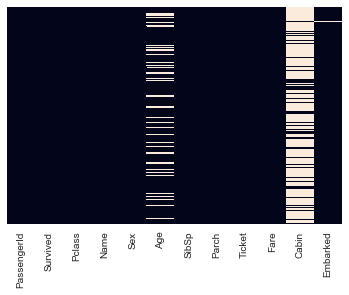

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False);

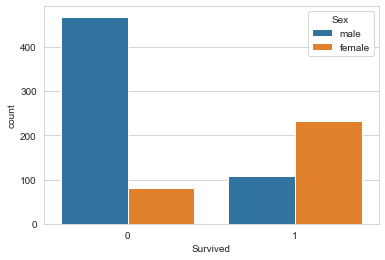

In [5]:
sns.countplot(x='Survived',data=train,hue='Sex');

Of those that perished the majority were male

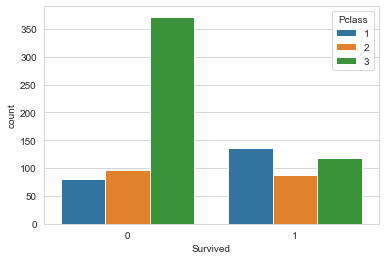

In [6]:
sns.countplot(x='Survived',data=train,hue='Pclass');

When looking at Survival by Class, the majority of those who perished were of 3rd class  
Of those who survived there seems to be an overall balance between classes with a slight lead in 1st class

Age distribution of the passengers below with highest counts being in the low 20s and high 20s/low 30s age ranges  
The passengers with missing age data obviously will not be part of this distribution

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


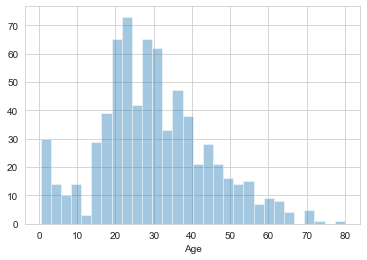

In [7]:
sns.distplot(train['Age'],bins=30,kde=False);

Count of passengers below travelling with spouse and/or siblings  
For each class the highest number of people were travelling alone while the highest number of families were travelling 3rd class

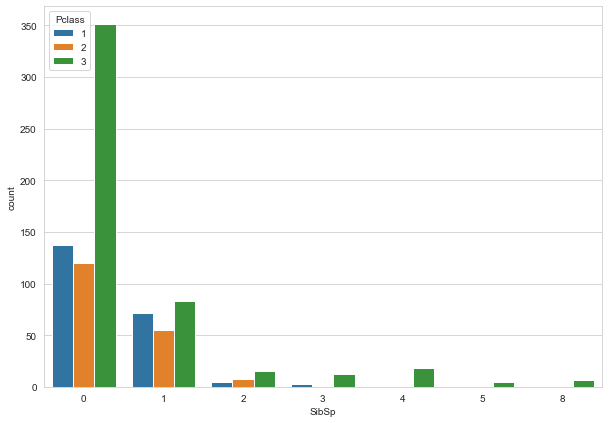

In [8]:
plt.figure(figsize=(10,7))
sns.countplot(x='SibSp',data=train,hue='Pclass');

Fare distribution divided by Class below   
Highest fare (> 500) paid by 1st class while most popular fair paid by 3rd class

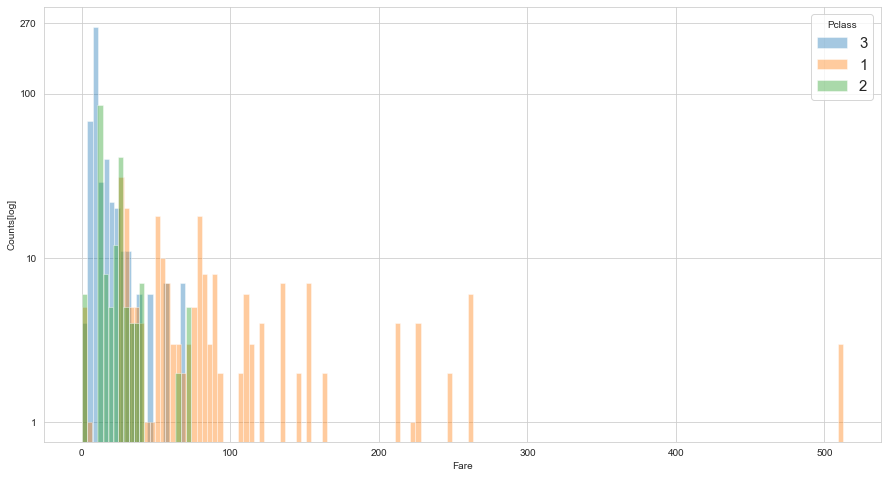

In [134]:
unique_classes = train['Pclass'].unique()
fig, ax = plt.subplots(figsize=(15, 8))
for classes in unique_classes:
    subset = train[train['Pclass'] == classes]['Fare']
    sns.distplot(subset,label = classes,kde=False, ax=ax, bins=int(subset.max()/3.5))
plt.legend(prop={'size': 15}, title = 'Pclass')
ax.set_yscale('log')
ax.set_yticks([1, 10, 100, 270])
ax.set_yticklabels([1, 10, 100, 270])
ax.set_ylabel('Counts[log]');

Survival numbers by Class and by Embarked (port of embarkment) where the highest number of people perished from each class when embarking at port S! 

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


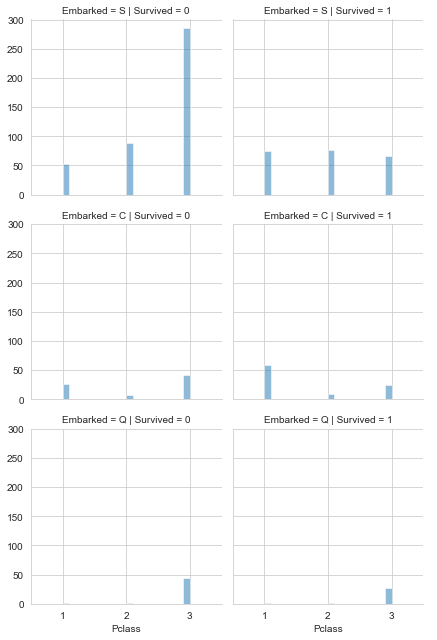

In [24]:
grid = sns.FacetGrid(train, col='Survived', row='Embarked', size=3)
grid.map(plt.hist, 'Pclass', alpha=.5, bins=20)
grid.set(xticks=[1, 2, 3], xlim=(0.5, 3.5))
grid.add_legend();

Boxplots of Age by Class and Sex  
As expected on average as age increases so does wealth; the women are on average younger than the men in each class; the smallest gap in average age between the sexes happens in 2nd class  
Even if I am not sure how exploring this can help with the model, I want to analyze as much as possible before building the predictions to become familiar with the data and check its quality

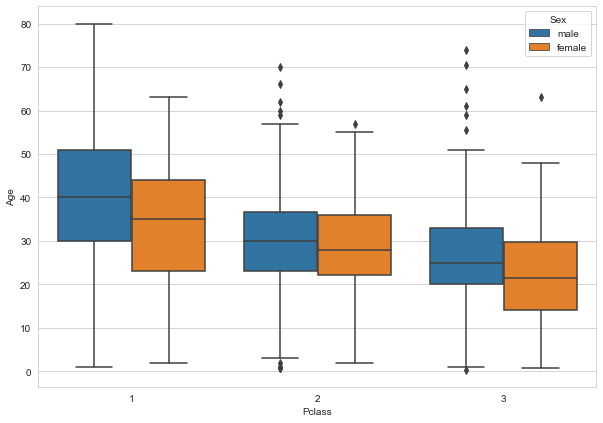

In [26]:
plt.figure(figsize=(10,7))
sns.boxplot(x=train['Pclass'],y=train['Age'],hue=train['Sex']);

Given the trends in the graph above I decide to go back to the Age feature and substitute those missing values with the averages for the same Class and Sex

In [68]:
mean_age = train.groupby(by=['Sex', 'Pclass']).mean()['Age'].round()
for _, row in train[train['Age'].isnull()].iterrows():
    train.loc[_, 'Age'] = mean_age[(row['Sex'], row['Pclass'])]

By applying the substitute age function to the dataset, the Age feature now has no missing values

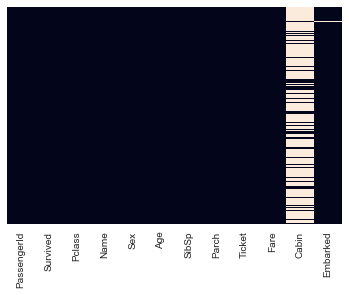

In [70]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False);

Since the Cabin values are related to what deck they were on, this might give insight on "survival by deck"  
Unfortunately, there are an overwhelming number of missing Cabin values and I cannot think of any sensible way that would make sense to implement them as done with the Age values  
I will drop this feature from the dataframe

In [71]:
train.drop('Cabin', inplace=True, axis=1)

The Cabin feature has been dropped and there are still some missing values regarding the Embarked feature (exactly 2 from the previously run train.info)  
I will use the most common value of the Embarked column and assign it to these missing values  

In [72]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode().values[0])

Check to see that all values are NON null

In [74]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Since the prediction model can only be built on numerical values I will encode the categorical features and drop the features that I don't think have an inpact on the outcome I am trying to predict (i.e. Passenger Id)

I can use dummy variables for the Sex and Embarked features

In [75]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embarked = pd.get_dummies(train['Embarked'], drop_first=True)

And drop the useless features: Ticket and PassengerId  
I am also dropping the "old" Sex and Embarked features since they will now be replaced

In [76]:
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

Adding the dummy variables to the dataframe  

In [77]:
train = pd.concat([train, sex, embarked], axis=1)

In [78]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Train Test Split of Data

Now I am ready to divide the data into a training set and a testing set    
The predictor variables will be the dataset minus the feature we want to predict: Survived  
The response variables instead will only be the feature Survived  

In [79]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']

Importing the "splitter"

In [80]:
from sklearn.model_selection import train_test_split

Performing the train and test split:

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Machine Learning Model Selection

Now I will run a few tests on a selection of different machine learning models to see how they perform
I will choose the best performing model and then try to optimize it further.

#### Logistic Regression

Import a logistic regression model

In [82]:
from sklearn.linear_model import LogisticRegression

Initialize the model (class)

In [83]:
lr_mod = LogisticRegression()

Fit the model to the training dataset  

In [84]:
lr_mod.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy score for logistic regression model on training set  

In [85]:
acc_lr = round(lr_mod.score(X_train, y_train), 3)

Now I make some predictions based on the testing dataset  

In [86]:
pred_lr = lr_mod.predict(X_test)

Accuracy and F-score calculation on the testing set which gives us an idea of how well the model makes predictions.  
**Accuracy** is defined as the overall fraction of predictions our model got right (survived or not)  
**Precision** measures how many of the positive predictions were correct: used when there is a high cost associated with False Positives, as in spam detection
**Recall** instead measures how many of the actual positives were labeled correctly as positive by the model: used when there is a high cost associated with False Negatives, as in cancer or in a contagious disease  
**F-score** combines precision and recall into one score and will be high only if both precision and recall are high

In [87]:
from sklearn.metrics import accuracy_score, f1_score
acc_pred_lr = round(accuracy_score(y_test, pred_lr), 3)
f1_lr = round(f1_score(y_test, pred_lr), 3)

Now I proceed to do the same for the other four models

#### K-Nearest Neighbor

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn_mod = KNeighborsClassifier(n_neighbors=3) 
knn_mod.fit(X_train, y_train)  

acc_knn = round(knn_mod.score(X_train, y_train), 3)
pred_knn = knn_mod.predict(X_test)  
acc_pred_knn = round(accuracy_score(y_test, pred_knn), 3)
f1_knn = round(f1_score(y_test, pred_knn), 3)

#### Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier

dt_mod = DecisionTreeClassifier() 
dt_mod.fit(X_train, y_train) 

acc_dt = round(dt_mod.score(X_train, y_train), 3)
pred_dt = dt_mod.predict(X_test) 
acc_pred_dt = round(accuracy_score(y_test, pred_dt), 3)
f1_dt = round(f1_score(y_test, pred_dt), 3)

#### Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf_mod = RandomForestClassifier(n_estimators=100)
rf_mod.fit(X_train, y_train)

acc_rf = round(rf_mod.score(X_train, y_train), 3)
pred_rf = rf_mod.predict(X_test)
acc_pred_rf = round(accuracy_score(y_test, pred_rf), 3)
f1_rf = round(f1_score(y_test, pred_rf), 3)

#### Support Vector Machines

In [90]:
from sklearn.svm import SVC

svm_mod = SVC()
svm_mod.fit(X_train,y_train)

acc_svm = round(svm_mod.score(X_train, y_train), 3)
pred_svm = svm_mod.predict(X_test)
acc_pred_svm = round(accuracy_score(y_test, pred_svm), 3)
f1_svm = round(f1_score(y_test, pred_svm), 3)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Model Accuracy and F-Score Comparisons

In order to see which model has the highest accuracy on the training set I run the following  

In [102]:
results_acc = pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression','Random Forest', 'Decision Tree'],
                            'Train_Acc_Score': [acc_svm, acc_knn, acc_lr, acc_rf, acc_dt]})
result_acc_df = results_acc.sort_values(by='Train_Acc_Score', ascending=False)
result_acc_df = result_acc_df.set_index('Train_Acc_Score')
result_acc_df

,Model
Train_Acc_Score,
0.981,Random Forest
0.981,Decision Tree
0.900,Support Vector Machines
0.820,KNN
0.804,Logistic Regression


The winning model is Random Forest

In order to see which model has the highest accuracy on making predictions from the testing set, I run the following   

In [104]:
results_acc_pred = pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression','Random Forest', 'Decision Tree'],
                           'Test_Acc_Score': [acc_pred_svm, acc_pred_knn, acc_pred_lr, acc_pred_rf, acc_pred_dt]})
result_acc_pred_df = results_acc_pred.sort_values(by='Test_Acc_Score', ascending=False)
result_acc_pred_df = result_acc_pred_df.set_index('Test_Acc_Score')
result_acc_pred_df

,Model
Test_Acc_Score,
0.806,Logistic Regression
0.791,Random Forest
0.754,Decision Tree
0.716,KNN
0.694,Support Vector Machines


The following gives the F-score on the model predictions  

In [105]:
results_f1 = pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression','Random Forest', 'Decision Tree'],
                           'Test_F_Score': [f1_svm, f1_knn, f1_lr, f1_rf, f1_dt]})
result_f1_df = results_f1.sort_values(by='Test_F_Score', ascending=False)
result_f1_df = result_f1_df.set_index('Test_F_Score')
result_f1_df

,Model
Test_F_Score,
0.752,Logistic Regression
0.743,Random Forest
0.700,Decision Tree
0.604,KNN
0.539,Support Vector Machines


So we have the Random Forest model highly accurate on the training data but the Logistic Regression model scoring better on predictions  
Since the Random Forest model allows for more refined hyper-parameter tuning, I will choose it and try to improve its performance  
I first want to see how the Random Forest model performs with K-Fold Cross-Validation 

In [106]:
from sklearn.model_selection import cross_val_score

rf_mod = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf_mod, X_train, y_train, cv=10, scoring = 'accuracy')

scores_mean = round(scores.mean(), 3)
scores_std = round(scores.std(), 3)

The average model accuracy is much more realistic and still pretty good  

In [108]:
print(f'Mean: {scores_mean}')
print(f'Stand Dev: {scores_std}')

Mean: 0.807
Stand Dev: 0.036


#### Improving Model Performance

GridSearch allows to test different hyper-parameter values by circling through iterations of the model;  
it then returns a report on the best performing settings for the parameters

In [109]:
from sklearn.model_selection import GridSearchCV
param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70],
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35],
              "n_estimators": [100, 400, 700, 1000, 1500]}
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy',
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

Now I can change the parameters that I have submitted in the grid and run GridSearch again to see if I can narrow in on even better parameters

In [110]:
param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [3, 4, 5, 6, 7],
              "min_samples_split" : [15, 20, 25, 30, 35],
              "n_estimators": [200, 300, 400, 500, 600]}
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy',
 'min_samples_leaf': 6,
 'min_samples_split': 25,
 'n_estimators': 400}

And a third time  

In [111]:
param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [5],
              "min_samples_split" : [23, 24, 25, 26, 27],
              "n_estimators": [350, 375, 400, 425, 450]}
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=42, n_jobs=-1)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'gini',
 'min_samples_leaf': 5,
 'min_samples_split': 24,
 'n_estimators': 350}

Refitting the model with the best parameters to obtain the new and improved Random Forest model

In [112]:
new_rf_mod = RandomForestClassifier(criterion="gini", 
                                    min_samples_leaf=5, 
                                    min_samples_split=24,   
                                    n_estimators=400, 
                                    max_features='auto', 
                                    oob_score=True, 
                                    random_state=42, 
                                    n_jobs=-1)
new_rf_mod.fit(X_train, y_train)
new_pred_rf = new_rf_mod.predict(X_test)
new_f1_rf = round(f1_score(y_test, new_pred_rf), 3)

Slight increase in the F-score on the model!  

In [113]:
print(new_f1_rf)

0.74


To get a broader picture of the state of the predictions, I can run a classification report and a confusion matrix  

In [114]:
from sklearn.metrics import classification_report,confusion_matrix
print('1 - Classification Report \n', classification_report(y_test,new_pred_rf))
print('2 - Confusion Matrix \n', confusion_matrix(y_test,new_pred_rf))

1 - Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.90      0.85       157
           1       0.83      0.67      0.74       111

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268

2 - Confusion Matrix 
 [[142  15]
 [ 37  74]]


ROC score measures how un-random a classifier is:  
a classifier with a ROC AUC Score of 1 is correct 100% of the time and a score of 0.5 indicates a completely random classiffier, as in flipping a coin

In [115]:
from sklearn.metrics import roc_auc_score

roc_score = roc_auc_score(y_test, new_pred_rf)
print(f"ROC-AUC-Score: {round(roc_score, 3)}")

ROC-AUC-Score: 0.786


### Cleaning up of the test csv

In [116]:
test = pd.read_csv('test.csv')

In [117]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


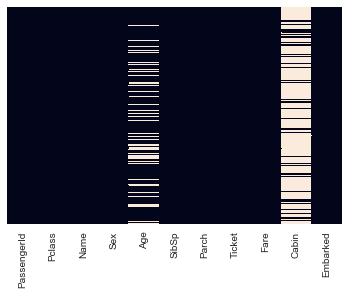

In [118]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False);

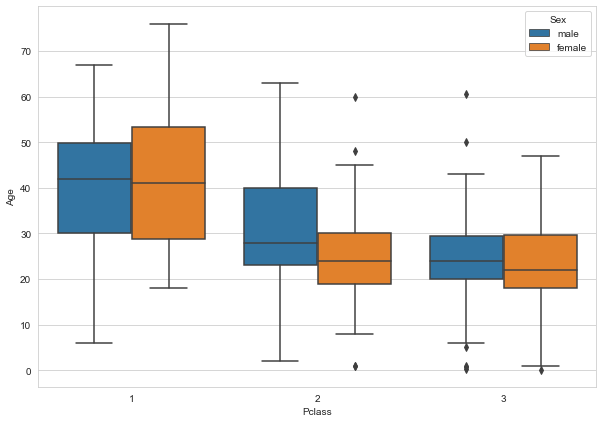

In [119]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=test, hue='Sex');

In [120]:
mean_age = test.groupby(by=['Sex', 'Pclass']).mean()['Age'].round()
for _, row in test[test['Age'].isnull()].iterrows():
    test.loc[_, 'Age'] = mean_age[(row['Sex'], row['Pclass'])]

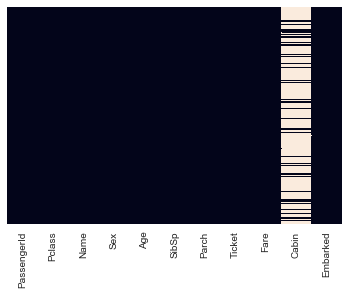

In [121]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False);

In [122]:
test.drop('Cabin', inplace=True, axis=1)

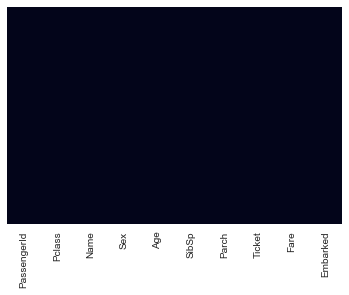

In [123]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False);

In [124]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [125]:
# adding the mean by class to the missing fare value
third_class_fare = test.groupby(by='Pclass').mean().loc[3, 'Fare']

In [126]:
test.loc[test['Fare'].isnull(),'Fare'] = third_class_fare

In [127]:
test['Fare'].isnull().sum()

0

In [128]:
# prepping the prediction submission file
predictions_submission = test[['PassengerId','Name']]
predictions_submission.head()

,PassengerId,Name
0,892,"Kelly, Mr. James"
1,893,"Wilkes, Mrs. James (Ellen Needs)"
2,894,"Myles, Mr. Thomas Francis"
3,895,"Wirz, Mr. Albert"
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)"


In [129]:
sex_test = pd.get_dummies(test['Sex'], drop_first=True)
embarked_test = pd.get_dummies(test['Embarked'], drop_first=True)

In [130]:
test.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

In [131]:
test = pd.concat([test,sex_test,embarked_test],axis=1)

In [132]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1


### Prediction submission

In [133]:
# predictions made with logistic model and test csv
predict_survival_rf= new_rf_mod.predict(test)

In [78]:
predict_survival_rf

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [79]:
predictions_submission_rf = predictions_submission.copy()
predictions_submission_rf['Survived'] = predict_survival_rf
predictions_submission_rf.drop('Name', axis=1, inplace=True)
predictions_submission_rf.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [80]:
predictions_submission_rf.to_csv(r'/Users/emilianohenry/ds/jupyter_notebooks/kaggle/predictions_submission_rf.csv',index=False)